<a href="https://colab.research.google.com/github/Soumya296/Deep_learning/blob/master/Hand_Sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#essential_libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import csv

#Deep learning framework
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense , Conv2D , Flatten ,MaxPool2D

In [3]:

tf.__version__

'2.3.0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/Projects
os.getcwd()

/content/drive/My Drive/Projects


'/content/drive/My Drive/Projects'

In [7]:
!ls

Datasets     My_model.h5py	  sign_mnist_train.csv
My_model.h5  sign_mnist_test.csv  training_1


In [8]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files


In [12]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)


In [13]:
def get_data(filename):
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',')
        first_line = True
        temp_images = []
        temp_labels = []
        for row in csv_reader:
            if first_line:
                # print("Ignoring first line")
                first_line = False
            else:
                temp_labels.append(row[0])
                image_data = row[1:785]
                image_data_as_array = np.array_split(image_data, 28)
                temp_images.append(image_data_as_array)
        images = np.array(temp_images).astype('float')
        labels = np.array(temp_labels).astype('float')
    return images, labels

training_images, training_labels = get_data('sign_mnist_train.csv')
testing_images, testing_labels = get_data('sign_mnist_test.csv')

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [14]:
training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

print(training_images.shape)
print(testing_images.shape)



(27455, 28, 28, 1)
(7172, 28, 28, 1)


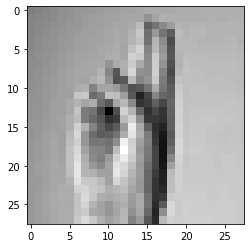

In [15]:
plt.imshow(training_images[42].reshape((28,28)),cmap ='gray')

In [16]:
training_gen = train_datagen.flow(training_images, training_labels, batch_size=32)
validation_gen=validation_datagen.flow(testing_images, testing_labels, batch_size=32)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer = 'he_normal',use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_initializer = 'he_normal',use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_initializer = 'he_normal',use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(26, activation=tf.nn.softmax)])

# Compile Model. 
model.compile(optimizer = 'nadam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(training_gen,
                              steps_per_epoch=len(training_images) / 32,
                              epochs=150,
                              validation_data = validation_gen,
                              validation_steps=len(testing_images) / 32,
                              callbacks = [cp_callback])

# training_images = training_images/255
testing_images = testing_images/255
# history = model.fit(x=training_images,y=training_labels,epochs = 150,batch_size = 32,validation_data = (testing_images,testing_labels))
model.evaluate(testing_images, testing_labels)



Epoch 1/150
657/857 [=====================>........] - ETA: 2s - loss: 2.8466 - accuracy: 0.1621

KeyboardInterrupt: ignored

In [19]:
model.load_weights(checkpoint_path)

In [20]:
model.evaluate(testing_images,testing_labels)

225/225 [==============================] - 1s 2ms/step - loss: 0.0303 - accuracy: 0.9918


[0.030299203470349312, 0.9917735457420349]

In [24]:
model.save('My_model.h5')

In [25]:
model_temp = keras.models.load_model('My_model.h5')
model_temp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               819200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

In [38]:
print(model_temp.predict_classes(testing_images)[:100])

[ 6  5 10  0  3 21 10 14  3  7  8  8 21 12  7  4 22  0  7  7  2  0 21  4
 10 15  2 15  7  1  7  8 13 19  3 21 13  3 18 14 15 23  8 15 14  5 17  4
 19 13 20 22 20  5 16 16 21  4  7 22 10 13 11 22  2 10  1  4 18  4 20  6
 15  4  3 20 15 11  2  2 17  2  7 21 23  7 12 17 24 14  2  1  7 23  8  5
  0  0 19 21]


In [39]:
testing_labels[:100]

array([ 6.,  5., 10.,  0.,  3., 21., 10., 14.,  3.,  7.,  8.,  8., 21.,
       12.,  7.,  4., 22.,  0.,  7.,  7.,  2.,  0., 21.,  4., 10., 15.,
        2., 15.,  7.,  1.,  7.,  8., 13., 19.,  3., 21., 13.,  3., 18.,
       14., 15., 23.,  8., 15., 14.,  5., 17.,  4., 19., 13., 20., 22.,
       20.,  5., 16., 16., 21.,  4.,  7., 22., 10., 13., 11., 22.,  2.,
       10.,  1.,  4., 18.,  4., 20.,  6., 15.,  4.,  3., 20., 15., 11.,
        2.,  2., 17.,  2.,  7., 21., 23.,  7., 12., 17., 24., 14.,  2.,
        1.,  7., 23.,  8.,  5.,  0.,  0., 19., 21.])